# 12.5. 多GPU训练

到目前为止，我们讨论了如何在CPU和GPU上高效地训练模型，同时在 12.3节中展示了深度学习框架如何在CPU和GPU之间自动地并行化计算和通信，还在 5.6节中展示了如何使用nvidia-smi命令列出计算机上所有可用的GPU。 但是我们没有讨论如何真正实现深度学习训练的并行化。 是否一种方法，以某种方式分割数据到多个设备上，并使其能够正常工作呢？ 本节将详细介绍如何从零开始并行地训练网络， 这里需要运用小批量随机梯度下降算法（详见 11.5节）。 后面我还讲介绍如何使用高级API并行训练网络（请参阅 12.6节）。

## 12.5.1. 问题拆分
我们从一个简单的计算机视觉问题和一个稍稍过时的网络开始。 这个网络有多个卷积层和汇聚层，最后可能有几个全连接的层，看起来非常类似于LeNet (LeCun et al., 1998)或AlexNet (Krizhevsky et al., 2012)。 假设我们有多个GPU（如果是桌面服务器则有$2$个，AWS g4dn.12xlarge上有$4$个，p3.16xlarge上有$8$个，p2.16xlarge上有$16$个）。 我们希望以一种方式对训练进行拆分，为实现良好的加速比，还能同时受益于简单且可重复的设计选择。 毕竟，多个GPU同时增加了内存和计算能力。 简而言之，对于需要分类的小批量训练数据，我们有以下选择。

第一种方法，在多个GPU之间拆分网络。 也就是说，每个GPU将流入特定层的数据作为输入，跨多个后续层对数据进行处理，然后将数据发送到下一个GPU。 与单个GPU所能处理的数据相比，我们可以用更大的网络处理数据。 此外，每个GPU占用的显存（memory footprint）可以得到很好的控制，虽然它只是整个网络显存的一小部分。

然而，GPU的接口之间需要的密集同步可能是很难办的，特别是层之间计算的工作负载不能正确匹配的时候， 还有层之间的接口需要大量的数据传输的时候（例如：激活值和梯度，数据量可能会超出GPU总线的带宽）。 此外，计算密集型操作的顺序对拆分来说也是非常重要的，这方面的最好研究可参见 (Mirhoseini et al., 2017)，其本质仍然是一个困难的问题，目前还不清楚研究是否能在特定问题上实现良好的线性缩放。 综上所述，除非存框架或操作系统本身支持将多个GPU连接在一起，否则不建议这种方法。

第二种方法，拆分层内的工作。 例如，将问题分散到$4$个GPU，每个GPU生成$16$个通道的数据，而不是在单个GPU上计算$64$个通道。 对于全连接的层，同样可以拆分输出单元的数量。 图12.5.1描述了这种设计，其策略用于处理显存非常小（当时为2GB）的GPU。 当通道或单元的数量不太小时，使计算性能有良好的提升。 此外，由于可用的显存呈线性扩展，多个GPU能够处理不断变大的网络。

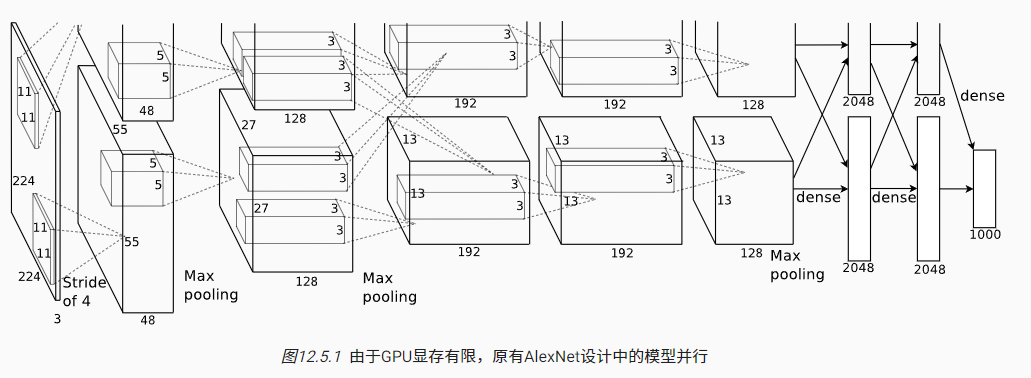

然而，我们需要大量的同步或屏障操作（barrier operation），因为每一层都依赖于所有其他层的结果。 此外，需要传输的数据量也可能比跨GPU拆分层时还要大。 因此，基于带宽的成本和复杂性，我们同样不推荐这种方法。

最后一种方法，跨多个GPU对数据进行拆分。 这种方式下，所有GPU尽管有不同的观测结果，但是执行着相同类型的工作。 在完成每个小批量数据的训练之后，梯度在GPU上聚合。 这种方法最简单，并可以应用于任何情况，同步只需要在每个小批量数据处理之后进行。 也就是说，当其他梯度参数仍在计算时，完成计算的梯度参数就可以开始交换。 而且，GPU的数量越多，小批量包含的数据量就越大，从而就能提高训练效率。 但是，添加更多的GPU并不能让我们训练更大的模型。

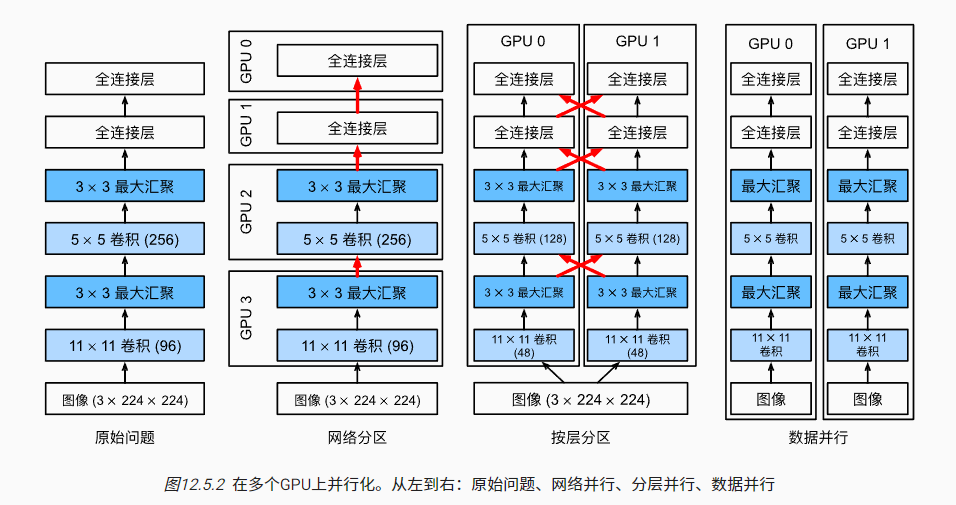

图12.5.2中比较了多个GPU上不同的并行方式。 总体而言，只要GPU的显存足够大，数据并行是最方便的。 有关分布式训练分区的详细描述，请参见 (Li et al., 2014)。 在深度学习的早期，GPU的显存曾经是一个棘手的问题，然而如今除了非常特殊的情况，这个问题已经解决。 下面我们将重点讨论数据并行性。

## 12.5.2. 数据并行性
假设一台机器有$k$个GPU。 给定需要训练的模型，虽然每个GPU上的参数值都是相同且同步的，但是每个GPU都将独立地维护一组完整的模型参数。 例如， 图12.5.3演示了在$k=2$时基于数据并行方法训练模型。



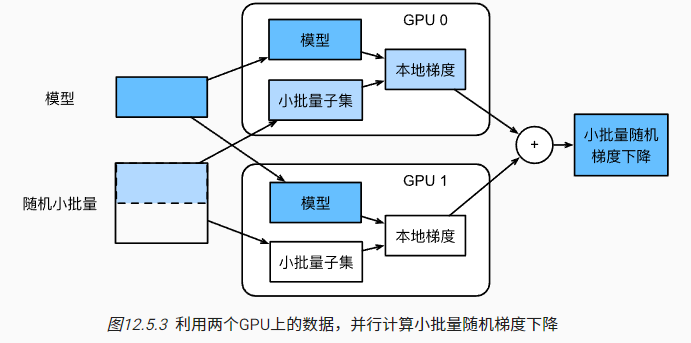

一般来说，$k$个GPU并行训练过程如下：

- 在任何一次训练迭代中，给定的随机的小批量样本都将被分成$k$个部分，并均匀地分配到GPU上；
- 每个GPU根据分配给它的小批量子集，计算模型参数的损失和梯度；
- 将$k$个GPU中的局部梯度聚合，以获得当前小批量的随机梯度；
- 聚合梯度被重新分发到每个GPU中；
- 每个GPU使用这个小批量随机梯度，来更新它所维护的完整的模型参数集。

在实践中请注意，当在$k$个GPU上训练时，需要扩大小批量的大小为$k$的倍数，这样每个GPU都有相同的工作量，就像只在单个GPU上训练一样。 因此，在16-GPU服务器上可以显著地增加小批量数据量的大小，同时可能还需要相应地提高学习率。 还请注意， 7.5节中的批量规范化也需要调整，例如，为每个GPU保留单独的批量规范化参数。

下面我们将使用一个简单网络来演示多GPU训练。

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

## 12.5.3. 简单网络
我们使用 6.6节中介绍的（稍加修改的）LeNet， 从零开始定义它，从而详细说明参数交换和同步。

In [2]:
# 初始化模型参数
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# 定义模型
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# 交叉熵损失函数
loss = nn.CrossEntropyLoss(reduction='none')

## 12.5.4. 数据同步
对于高效的多GPU训练，我们需要两个基本操作。 首先，我们需要向多个设备分发参数并附加梯度（get_params）。 如果没有参数，就不可能在GPU上评估网络。 第二，需要跨多个设备对参数求和，也就是说，需要一个allreduce函数。

In [3]:
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

通过将模型参数复制到一个GPU。

In [4]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 权重:', new_params[1])
print('b1 梯度:', new_params[1].grad)

b1 权重: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 梯度: None


由于还没有进行任何计算，因此权重参数的梯度仍然为零。 假设现在有一个向量分布在多个GPU上，下面的allreduce函数将所有向量相加，并将结果广播给所有GPU。 请注意，我们需要将数据复制到累积结果的设备，才能使函数正常工作。

In [5]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)

通过在不同设备上创建具有不同值的向量并聚合它们。

In [6]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('allreduce之前：\n', data[0], '\n', data[1])
allreduce(data)
print('allreduce之后：\n', data[0], '\n', data[1])

allreduce之前：
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
allreduce之后：
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


## 12.5.5. 数据分发
我们需要一个简单的工具函数，将一个小批量数据均匀地分布在多个GPU上。 例如，有两个GPU时，我们希望每个GPU可以复制一半的数据。 因为深度学习框架的内置函数编写代码更方便、更简洁，所以在$4 \times 5$矩阵上使用它进行尝试。

In [7]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

IndexError: list index out of range

为了方便以后复用，我们定义了可以同时拆分数据和标签的split_batch函数。

In [8]:
#@save
def split_batch(X, y, devices):
    """将X和y拆分到多个设备上"""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))

## 12.5.6. 训练
现在我们可以在一个小批量上实现多GPU训练。 在多个GPU之间同步数据将使用刚才讨论的辅助函数allreduce和split_and_load。 我们不需要编写任何特定的代码来实现并行性。 因为计算图在小批量内的设备之间没有任何依赖关系，因此它是“自动地”并行执行。

In [9]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # 在每个GPU上分别计算损失
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # 反向传播在每个GPU上分别执行
        l.backward()
    # 将每个GPU的所有梯度相加，并将其广播到所有GPU
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce(
                [device_params[c][i].grad for c in range(len(devices))])
    # 在每个GPU上分别更新模型参数
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # 在这里，我们使用全尺寸的小批量

现在，我们可以定义训练函数。 与前几章中略有不同：训练函数需要分配GPU并将所有模型参数复制到所有设备。 显然，每个小批量都是使用train_batch函数来处理多个GPU。 我们只在一个GPU上计算模型的精确度，而让其他GPU保持空闲，尽管这是相对低效的，但是使用方便且代码简洁。

In [10]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # 将模型参数复制到num_gpus个GPU
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # 为单个小批量执行多GPU训练
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # 在GPU0上评估模型
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'测试精度：{animator.Y[0][-1]:.2f}，{timer.avg():.1f}秒/轮，'
          f'在{str(devices)}')

让我们看看在单个GPU上运行效果得有多好。 首先使用的批量大小是$256$，学习率是$0.2$。

测试精度：0.80，3.9秒/轮，在[device(type='cuda', index=0)]


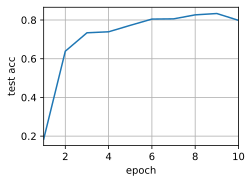

In [11]:
train(num_gpus=1, batch_size=256, lr=0.2)

保持批量大小和学习率不变，并增加为2个GPU，我们可以看到测试精度与之前的实验基本相同。 不同的GPU个数在算法寻优方面是相同的。 不幸的是，这里没有任何有意义的加速：模型实在太小了；而且数据集也太小了。在这个数据集中，我们实现的多GPU训练的简单方法受到了巨大的Python开销的影响。 在未来，我们将遇到更复杂的模型和更复杂的并行化方法。 尽管如此，让我们看看Fashion-MNIST数据集上会发生什么。

ValueError: Expected a non cpu device, but got: cpu

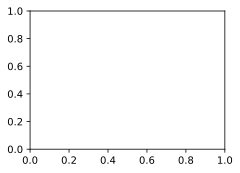

In [12]:
train(num_gpus=2, batch_size=256, lr=0.2)

## 12.5.7. 小结
- 有多种方法可以在多个GPU上拆分深度网络的训练。拆分可以在层之间、跨层或跨数据上实现。前两者需要对数据传输过程进行严格编排，而最后一种则是最简单的策略。
- 数据并行训练本身是不复杂的，它通过增加有效的小批量数据量的大小提高了训练效率。
- 在数据并行中，数据需要跨多个GPU拆分，其中每个GPU执行自己的前向传播和反向传播，随后所有的梯度被聚合为一，之后聚合结果向所有的GPU广播。
- 小批量数据量更大时，学习率也需要稍微提高一些。

## 12.5.8. 练习
1. 在$k$个GPU上进行训练时，将批量大小从$b$更改为$k\cdot b$，即按GPU的数量进行扩展。
2. 比较不同学习率时模型的精确度，随着GPU数量的增加学习率应该如何扩展？
3. 实现一个更高效的allreduce函数用于在不同的GPU上聚合不同的参数？为什么这样的效率更高？
4. 实现模型在多GPU下测试精度的计算。